# Getting Started with OneMax

This tutorial explains how to implement custom representations. It implements the following components:

- Implement a representation (how do I ref. sections?) {TODO}

In [22]:
import os
import sys
nb_dir = os.path.abspath(os.path.join('..', '..', '..', '..'))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

## Representation

To begin, implement a custom representation.

All custom representations must (a) derive `evokit.core.population.Individual`, (b) store the genotype in `Individual.genome`, and (c) override `Individual.copy`.

The implementation decides how to create new individuals. Here, the class `BinaryString` implements a factory method `BinaryString.random`, which creates a uniformly random bit string of a certain length.

In [23]:
from __future__ import annotations
from typing import List, Self

from random import getrandbits
from evokit.core.population import Individual

class BinaryString(Individual[List[int]]):
    def __init__(self, value: List[int]) -> None:
        self.genome: List[int] = value

    @staticmethod
    def random(len: int) -> BinaryString:
        return BinaryString(
            (len * [0] +
                [int(digit) for digit in bin(getrandbits(len))[2:]])[-len:]
        )

    def copy(self: Self) -> Self:
        return type(self)(self.genome.copy())

    def __str__(self: Self) -> str:
        return str(self.genome)

## Variator

Implement a custom variator of `BinaryString`. All variators must derive `evokit.core.variator.Variator` and override `Variator.vary`.

This variator has `.arity=1`, means that it only takes one parent. Consequently, its `.vary` method can expect a tuple of size 1.

The implementation of `.vary` returns a tuple of size 1. To inform the user of this behaviour, the implementation should set `.coarity=2`.

In [24]:
from random import random
from typing import Sequence, Tuple

from evokit.core.variator import Variator

class RandomBitMutator(Variator[BinaryString]):
    def __init__(self, mutation_rate: float):
        self.arity = 1
        self.coarity = 2
        if (mutation_rate < 0 or mutation_rate > 1):
            raise ValueError(f"Mutation rate must be within {0} and {1}."
                             f"Got: {mutation_rate}")
        self.mutation_rate = mutation_rate

    def vary(self, parents: Sequence[BinaryString]) -> Tuple[BinaryString, ...]:
        offspring = parents[0].copy()

        for i in range(0, len(offspring.genome)):
            if (random() < self.mutation_rate):
                offspring.genome[i] = 1 if offspring.genome[i] == 0 else 1

        return (offspring,)

# Evaluator

Then, implement a custom evaluator of `BinaryString`.

All custom evaluators must derive `evokit.core.evaluator.Evaluator` and override `Evaluator.evaluate`. Here, `BitDistanceEvaluator` sums all bits in the genotype of a `BinaryString`.

In [25]:
from evokit.core.evaluator import Evaluator
from typing import override

class BitDistanceEvaluator(Evaluator[BinaryString]):
    @override
    def evaluate(self, s1: BinaryString) -> float:
        return sum(s1.genome)

## Put Everything Together

Create and run an evolutionary algorithm using components that have already been defined.

Since selectors and the overall algorithm do not depend on representations, the framework comes with generic ones thatare compatible with all representations.

Import a selector and an algorithm from `evokit.core.selector` and `evokit.core.algorithm` respectively:

- Together, `Elitist` and `SimpleSelector` form an elitist selector that always selects for highest-fitness individuals.
- The `SimpleLinearController` applies operators in the following order:

  1. **evaluate** for selection
  2. **selection**
  3. *update population*
  4. **vary** parents
  5. *update population*

In [26]:
from evokit.core.selector import Elitist, SimpleSelector

from evokit.core.algorithm import SimpleLinearAlgorithm

### Initialise Population

Create a number of `BinaryString` instances, then store them in a `Population`.

In [27]:
from evokit.core.population import Population

BINSTRING_LENGTH: int = 1000
POPULATION_SIZE: int = 20
GENERATION_COUNT: int = 100
init_pop = Population[BinaryString]()

for i in range(0, POPULATION_SIZE):
    init_pop.append(BinaryString.random(BINSTRING_LENGTH))

### Define the Algorithm

Initialise operators, then run the algorithm with these operators.

In [28]:
ctrl: SimpleLinearAlgorithm = SimpleLinearAlgorithm(
    population=init_pop,
    variator=RandomBitMutator(0.1),
    selector=Elitist(SimpleSelector[BinaryString](POPULATION_SIZE)),
    evaluator = BitDistanceEvaluator()
)

### Run the Algorithm

Run the algorithm, then retain the best individual of each generation. Remember to call `copy`, so that subsequent modifications on the individual do not affect the retained copy.

In [29]:
bests = []

for _ in range(GENERATION_COUNT):
    ctrl.step()
    bests.append(ctrl.population[0])

### Analyse Results

Print best individuals of the first and last generations. Note the that the latter has significantly higher fitness.

In [30]:
print(f"Best individual of the first generation is {bests[0]}")
print(f"    with fitness {sum(bests[0].genome)}")
print(f"Best individual of the last generation is {bests[-1]}")
print(f"    with fitness {sum(bests[-1].genome)}")

Best individual of the first generation is [1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,

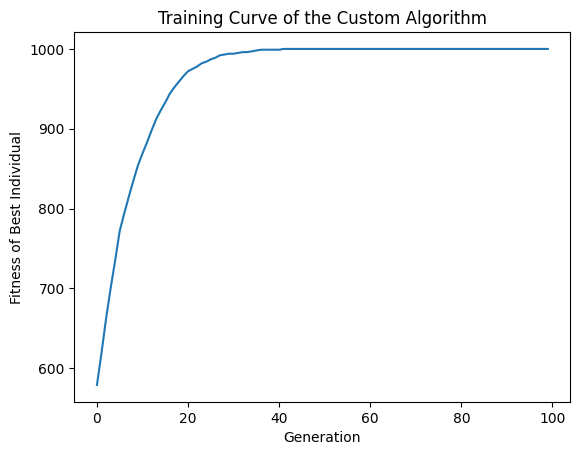

In [31]:
from matplotlib import pyplot as plt
plt.title('Training Curve of the Custom Algorithm')
plt.xlabel('Generation')
plt.ylabel('Fitness of Best Individual')
plt.plot([i for i in range(len(bests))], [sum(x.genome) for x in bests])
plt.show()